In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [71]:
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# what is the last date in our data set
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_day 

('2017-08-23')

In [11]:
lastDayinDB = dt.date(2017, 8, 23)
lastDayinDB

datetime.date(2017, 8, 23)

In [12]:
# Calculate the date 1 year ago from the last data point in the database
OneYearAgo = lastDayinDB - dt.timedelta(days = 365)
OneYearAgo

datetime.date(2016, 8, 23)

In [76]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= OneYearAgo).all()


In [44]:
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year)
last_year_dates_df = last_year_df.set_index('date')


In [45]:
# last_year_dates_df['date']= pd.to_datetime(last_year_dates_df['date'])

In [48]:
# Sort the dataframe by date
last_year_dates_df = last_year_dates_df.sort_values(by='date')

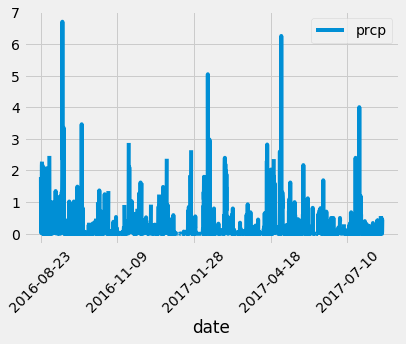

In [77]:
# Use Pandas Plotting with Matplotlib to plot the data
last_year_dates_df.plot(rot=45)

In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_dates_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
station_count

9

In [30]:
inspector = inspect(engine)

In [31]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [55]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [56]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [58]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [63]:
# Choose the station with the highest number of temperature observations.

session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()

('USC00519281', 2772)

In [79]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_day_max_station = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).first()
last_day_max_station


('2017-08-18')

In [65]:
lastDayforStation = dt.date(2017, 8, 18)
OneYearAgoforStation = lastDayforStation - dt.timedelta(days = 365)
OneYearAgoforStation

datetime.date(2016, 8, 18)

In [83]:
year_temp = session.query(Measurement.tobs).\
    filter(Measurement.date >= OneYearAgoforStation).filter(Measurement.station == 'USC00519281').all()


In [68]:
year_temp_df = pd.DataFrame(year_temp)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001985851CB48>]],
      dtype=object)

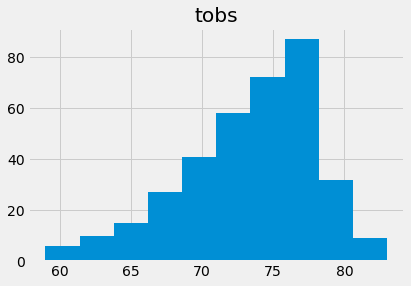

In [69]:
year_temp_df.hist()

## Bonus Challenge Assignment

In [89]:
start_temp = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= 2014-8-1).all()

In [84]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [85]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2014-08-01', '2014-08-15'))

[(68.0, 76.7864077669903, 83.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
